# **Stochastische Prozesse und Zeitreihen**

In dieser Mini-Challenge 

## Zielsetzung

- Wir modellieren die wöchentliche Influenza-Inzidenz in der Schweiz als Zeitreihe.
- Ziel ist es, Prognosen für die nächsten 4 Kalenderwochen zu erstellen.
- Wir vergleichen einfache Basismodelle (z.B. „letzte beobachtete Woche“ oder „gleiche Woche des Vorjahres“) mit einem ARIMA-basierten Modell und beurteilen die Prognosegüte anhand von Metriken wie MAE und RMSE.

## **Exploration und technische Vorbereitung**

In [7]:
# Datenverarbeitung und Visualisierung
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Zum Zerlegen von Zeitreihen in Trend-, Saison- und Residualkomponenten
from statsmodels.tsa.seasonal import seasonal_decompose

# Bibliotheken für Prognosemodelle (z.B. AutoARIMA, SARIMA)
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Für die Auswertung der Prognosegüte
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Warning suppress
import warnings
warnings.filterwarnings('ignore')

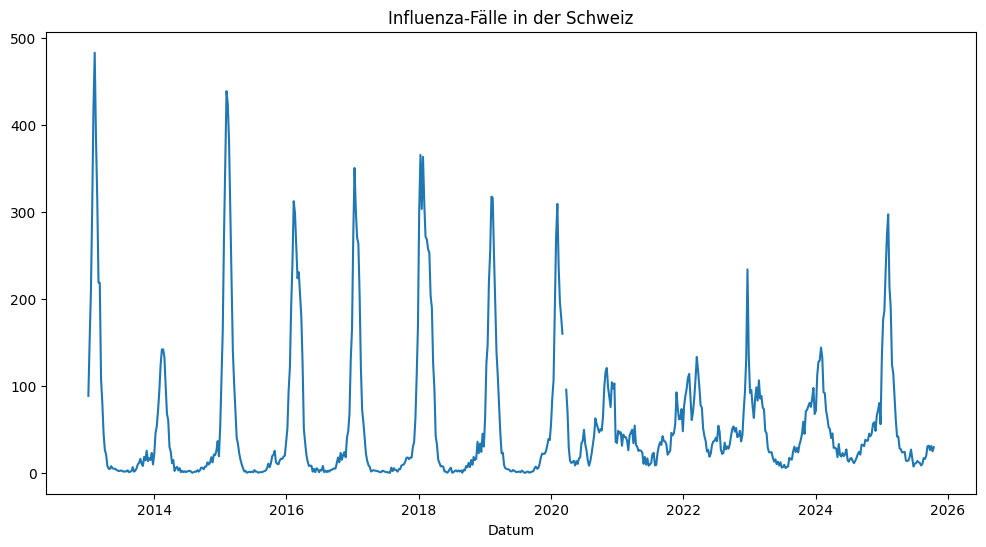

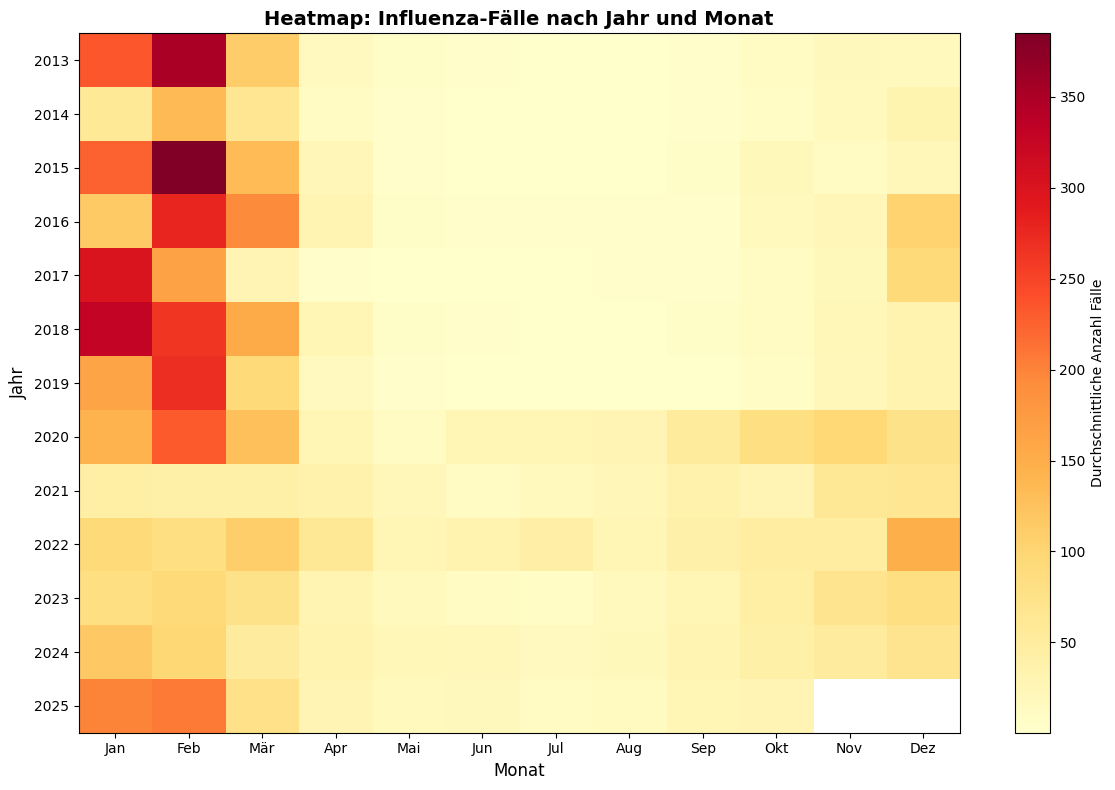

Fehlende Werte pro Spalte:
incValue    2
dtype: int64
Gesamtzahl fehlender Werte: 2
Fehlende Daten an folgenden Zeitpunkten:
DatetimeIndex(['2020-03-11', '2020-03-18'], dtype='datetime64[ns]', name='date', freq=None)


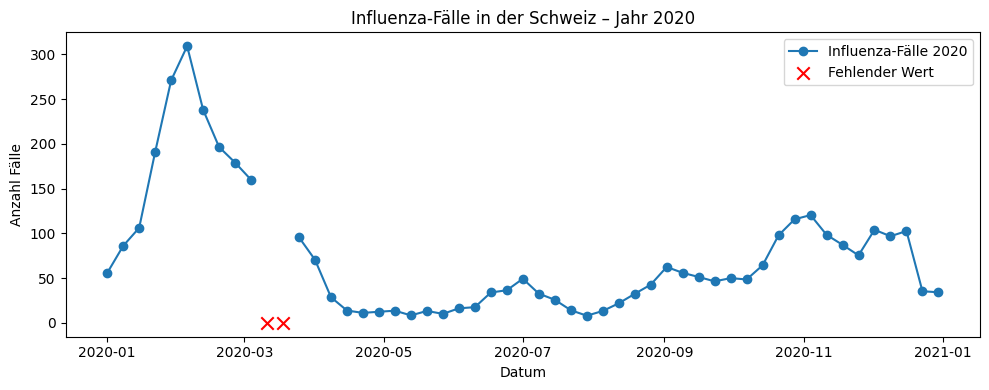

In [2]:
# Daten laden - Influenza-Fälle in der Schweiz
df_influenza = pd.read_csv('data/influenza_cases_ch.csv', parse_dates=['date'])
df_influenza.set_index('date', inplace=True)

# ------------------------------------------------------------
# Datenvisualisierung alle Daten
plt.figure(figsize=(12, 6))
plt.plot(df_influenza, label='Influenza-Fälle')
plt.title('Influenza-Fälle in der Schweiz')
plt.xlabel('Datum')

# ------------------------------------------------------------
# Heatmap: Influenza-Fälle nach Jahr und Monat
fig, ax = plt.subplots(figsize=(12, 8))

df_heatmap = df_influenza.copy()
df_heatmap['year'] = df_heatmap.index.year
df_heatmap['month'] = df_heatmap.index.month
pivot_table = df_heatmap.pivot_table(values=df_heatmap.columns[0], 
                                      index='year', 
                                      columns='month', 
                                      aggfunc='mean')

im = ax.imshow(pivot_table.values, aspect='auto', cmap='YlOrRd', interpolation='nearest')
ax.set_xticks(range(12))
ax.set_xticklabels(['Jan', 'Feb', 'Mär', 'Apr', 'Mai', 'Jun', 
                     'Jul', 'Aug', 'Sep', 'Okt', 'Nov', 'Dez'])
ax.set_yticks(range(len(pivot_table.index)))
ax.set_yticklabels(pivot_table.index)
ax.set_title('Heatmap: Influenza-Fälle nach Jahr und Monat', fontsize=14, fontweight='bold')
ax.set_xlabel('Monat', fontsize=12)
ax.set_ylabel('Jahr', fontsize=12)
plt.colorbar(im, ax=ax, label='Durchschnittliche Anzahl Fälle')

plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# Allgemeiner Check, wo Daten fehlen
missing_data = df_influenza.isnull().sum()
print("Fehlende Werte pro Spalte:")
print(missing_data)

# Gesamtzahl fehlender Einträge
total_missing = df_influenza.isnull().sum().sum()
print(f"Gesamtzahl fehlender Werte: {total_missing}")

# Zeitraum(e), in denen Daten fehlen (Datum anzeigen, wo NaN)
missing_rows = df_influenza[df_influenza.isnull().any(axis=1)]
if not missing_rows.empty:
    print("Fehlende Daten an folgenden Zeitpunkten:")
    print(missing_rows.index)
else:
    print("Keine fehlenden Daten im DataFrame vorhanden.")

# ------------------------------------------------------------
# Plot der Influenza-Fälle für das Jahr 2020, um fehlende Daten zu identifizieren
df_2020 = df_influenza[df_influenza.index.year == 2020]
plt.figure(figsize=(10, 4))
plt.plot(df_2020, marker='o', linestyle='-', label='Influenza-Fälle 2020')
plt.title('Influenza-Fälle in der Schweiz – Jahr 2020')
plt.xlabel('Datum')
plt.ylabel('Anzahl Fälle')

# Fehltstellen (NaN) visuell markieren
missing = df_2020[df_2020.isnull().any(axis=1)]
if not missing.empty:
    plt.scatter(missing.index, [0]*len(missing), color='red', label='Fehlender Wert', zorder=5, marker='x', s=80)

plt.legend()
plt.tight_layout()
plt.show()



**Analyse der saisonalen Influenza-Entwicklung**

Die Visualisierungen zeigen eine ausgeprägte saisonale Dynamik der Influenza-Fälle in der Schweiz. Typischerweise treten die höchsten Fallzahlen in den Wintermonaten Januar und Februar auf, gefolgt von einem raschen Rückgang ab März. Dieses Muster ist über viele Jahre hinweg klar erkennbar.

Das Jahr 2014 stellt einen deutlichen Ausreisser dar. Während in den meisten Jahren bis 2020 starke Winterpeaks auftreten, bleibt die Grippesaison 2013/14 ungewöhnlich mild. Die Heatmap zeigt im Januar und Februar 2014 deutlich niedrigere Werte im Vergleich zu den Vorjahren und Nachfolgejahren. Epidemiologische Berichte bestätigen, dass die Saison 2013/14 in Europa allgemein schwach ausgeprägt war. Die Gründe liegen unter anderem in einer geringen Verbreitung stark virulenter Influenzastämme sowie einer insgesamt mild verlaufenden Wintersaison [1].

Ab dem Jahr 2020 verändert sich das Muster sichtbar. Die traditionellen Winterspitzen fehlen fast vollständig. Dies fällt genau mit dem Beginn der COVID-19-Pandemie zusammen. Durch Massnahmen wie Social Distancing, Lockdowns, Maskenpflicht und reduzierte Mobilität wurden nicht nur COVID-19-Infektionen, sondern auch klassische Atemwegserkrankungen wie Influenza stark zurückgedrängt [2]. Die Heatmap verdeutlicht diesen Effekt: Ab 2020 erscheinen die Wintermonate deutlich heller, was auf drastisch geringere Fallzahlen hinweist. Erst ab 2022/2023 ist wieder ein leichtes Ansteigen der Influenza-Aktivität zu erkennen.

Zusätzlich weist der Plot der Influenza-Fälle im Jahr 2020 zwei klar erkennbare Ausreißer in Form fehlender Werte an den Zeitpunkten 11. März 2020 und 18. März 2020 aus (Wochen 11 & 12). Diese fehlenden Datenpunkte sind im Diagramm durch rote Markierungen gekennzeichnet. Obwohl sie den Gesamteindruck der saisonalen Entwicklung nicht wesentlich verändern, ist ihre explizite Dokumentation für die Transparenz der Datenqualität wichtig. Die fehlenden Werte lassen sich derzeit nicht kausal erklären; sie stehen jedoch sehr wahrscheinlich im Zusammenhang mit der beginnenden Covid-19-Pandemiewelle und den dadurch veränderten Melde- und Testprozessen. Vgl. BAG-Bulletin 45/21: Hinweise zu geschätzten Werten für die Wochen 11–12/2020 und den Einfluss der Covid-19-Pandemie auf die ILI-Überwachung [2].

Als nächsten Schritt werden wir die Daten analog zum BAG anpassen. Bei den Inzidenzen der Wochen 11 & 12 verwenden wir geschätzte Werte, basierend auf den Inzidenzen der Wochen 10 und 13, um die Darstellung konsistent und methodisch nachvollziehbar zu halten.

[1] European Centre for Disease Prevention and Control. Influenza in Europe – Season 2013–2014. Stockholm: ECDC; 2014. Online. Available: https://www.ecdc.europa.eu/en/publications-data/seasonal-influenza-annual-epidemiological-report-2013-14-season.

[2] Bundesamt für Gesundheit (BAG), “Saisonale Grippe im Winter 2020/2021,” BAG-Bulletin 40/20, 28. Sept. 2020. Online. Available: https://www.infovac.ch/docs/public/influenza/bag-bulletin-influenza-2020-21.pdf. 


In [3]:
# Fehlende Werte für Wochen 11 und 12 im Jahr 2020 durch lineare Interpolation zwischen KW10 und KW13 auffüllen
missing_weeks = df_2020[df_2020['incValue'].isnull()].index.isocalendar().week.tolist()

# Stelle sicher, dass beide Wochen fehlen & es gibt Werte für KW10 und KW13
if set(missing_weeks) == {11, 12}:
    week10_row = df_2020[df_2020.index.isocalendar().week == 10]['incValue']
    week13_row = df_2020[df_2020.index.isocalendar().week == 13]['incValue']

    if len(week10_row) == 1 and len(week13_row) == 1:
        week10_val = week10_row.values[0]
        week13_val = week13_row.values[0]

        # Werte für KW11 und KW12 interpolieren
        interp_kw11 = week10_val + (week13_val - week10_val) / 3
        interp_kw12 = week10_val + 2 * (week13_val - week10_val) / 3

        for idx in df_2020[df_2020['incValue'].isnull()].index:
            week_num = idx.isocalendar().week
            if week_num == 11:
                df_influenza.loc[idx, 'incValue'] = interp_kw11
                print(f"KW11/2020 mittels linearer Interpolation ({interp_kw11:.2f}) gefüllt.")
            elif week_num == 12:
                df_influenza.loc[idx, 'incValue'] = interp_kw12
                print(f"KW12/2020 mittels linearer Interpolation ({interp_kw12:.2f}) gefüllt.")
    else:
        print("Benötigte Werte für KW10 und/oder KW13 nicht gefunden – keine Imputation durchgeführt.")
else:
    print("Die erwarteten Fehlstellen (KW 11 & 12/2020) wurden nicht oder nicht nur gefunden – keine automatische Imputation durchgeführt.")


KW11/2020 mittels linearer Interpolation (138.43) gefüllt.
KW12/2020 mittels linearer Interpolation (116.99) gefüllt.


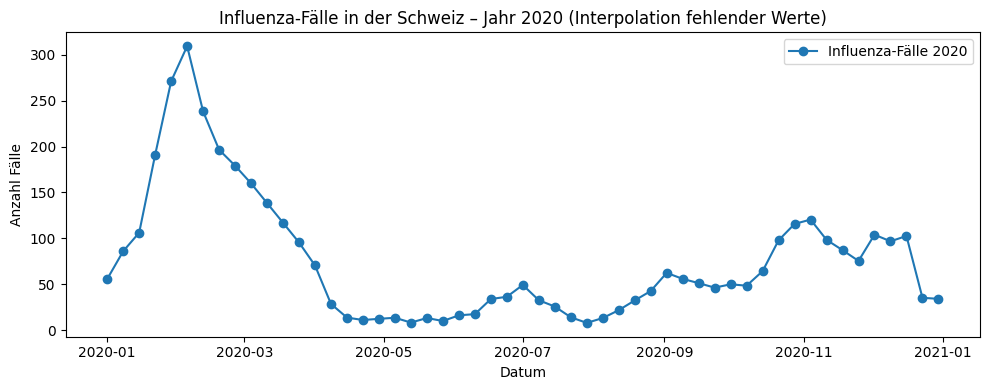

In [6]:
# ------------------------------------------------------------
# Plot der Influenza-Fälle für das Jahr 2020, um fehlende Daten zu identifizieren
df_2020 = df_influenza[df_influenza.index.year == 2020]
plt.figure(figsize=(10, 4))
plt.plot(df_2020, marker='o', linestyle='-', label='Influenza-Fälle 2020')
plt.title('Influenza-Fälle in der Schweiz – Jahr 2020 (Interpolation fehlender Werte)')
plt.xlabel('Datum')
plt.ylabel('Anzahl Fälle')

# Fehltstellen (NaN) visuell markieren
missing = df_2020[df_2020.isnull().any(axis=1)]
if not missing.empty:
    plt.scatter(missing.index, [0]*len(missing), color='red', label='Fehlender Wert', zorder=5, marker='x', s=80)

plt.legend()
plt.tight_layout()
plt.show()

In [9]:
# Überprüfen, ob noch fehlende Werte in df_influenza vorhanden sind
missing_count = df_influenza['incValue'].isnull().sum()
if missing_count > 0:
    print(f"Achtung: Es sind noch {missing_count} fehlende Werte (NaN) in der Zeitreihe vorhanden.")
    print(df_influenza[df_influenza['incValue'].isnull()])
else:
    print("Keine fehlenden Werte (NaN) in der Zeitreihe gefunden.")


Keine fehlenden Werte (NaN) in der Zeitreihe gefunden.


## Zerlegung der Zeitreihe

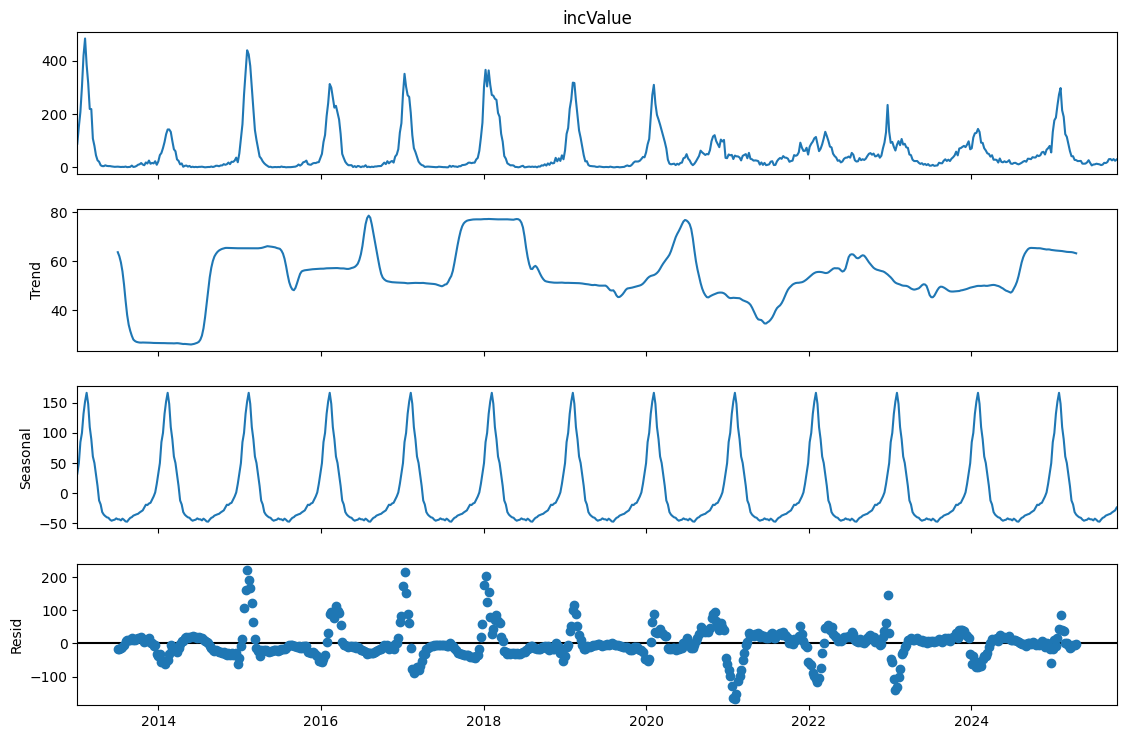

In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose

y = df_influenza['incValue']

decomp = seasonal_decompose(y, model='additive')

fig = decomp.plot()
fig.set_size_inches(12, 8)
plt.show()

**Originalzeitreihe**: Die Influenza-Inzidenz zeigt klar ausgeprägte Peaks, wie analysiert meist in den Monaten Januar und Februar. Diese Peaks fehlen ab 2020 während der Covid-Pandemie. Man sieht eine langsame Wiederkehr dieser Peaks ab 2022 und 2023.

**Trend**: Der Trend zeigt langfristige strukturelle Veränderungen im Übertragungsgeschehen. Genau das meint das Drehbuch des Kurses, Trends können exogene Effekte widerspiegeln wie Pandemiemassnahmen, Klima und Mobilität.

**Saisonalität**: Die Saisonalität zeigt das regelmässige und wiederkehrende Muster der Winterepidemien mit deutlichen Spitzen in den Winterwochen. Das Muster bleibt über die Jahre hinweg sehr stabil und bildet die jährlichen Grippesaisonen konsistent ab.

**Residuen**: Die Residuen zeigen die kurzfristigen und nicht erklärbaren Schwankungen. Man sieht grössere Ausschläge in starken Grippesaisonen und systematische negative Werte während der Covid-Pandemie, weil hier trotz erwarteter Saisonalität kaum Fälle aufgetreten sind.

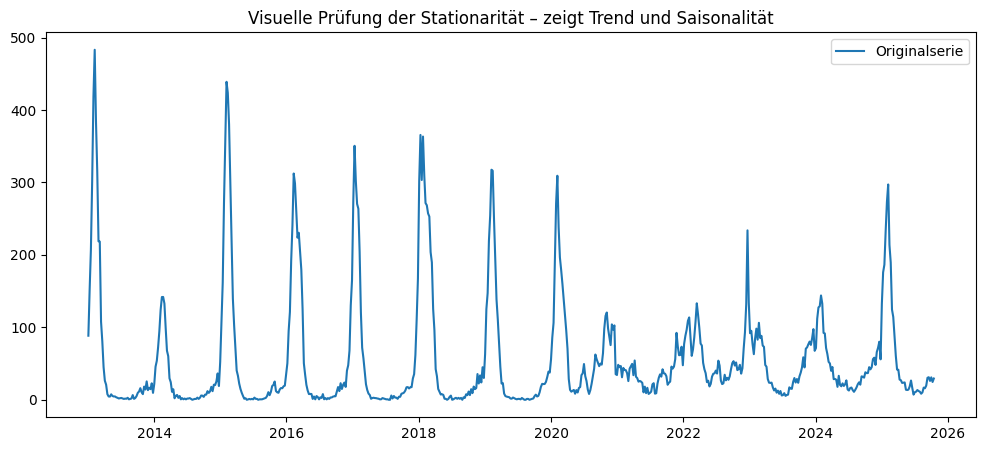

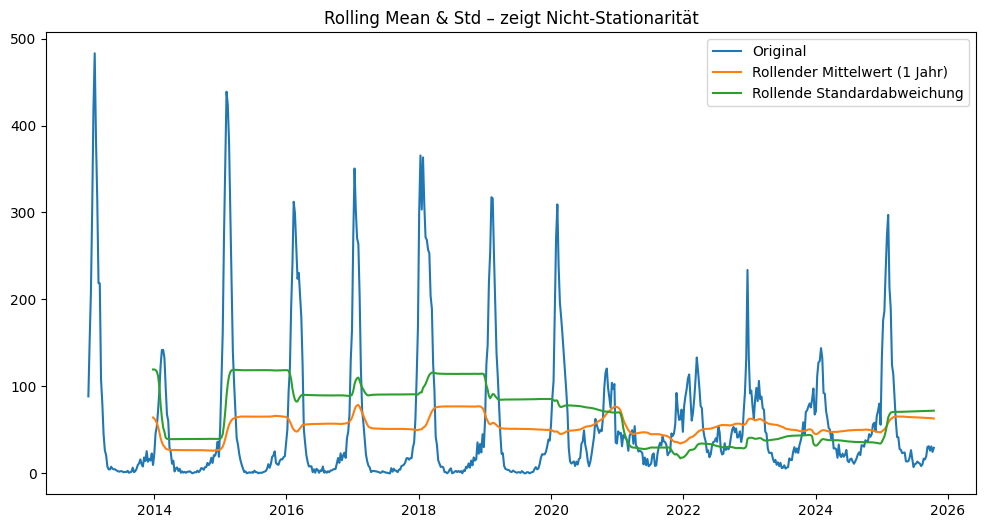

ADF-Statistik: -7.62772223887751
p-Wert: 2.0474752791286908e-11
Kritische Werte: {'1%': -3.4403271946832645, '5%': -2.8659424728408456, '10%': -2.5691144817582985}


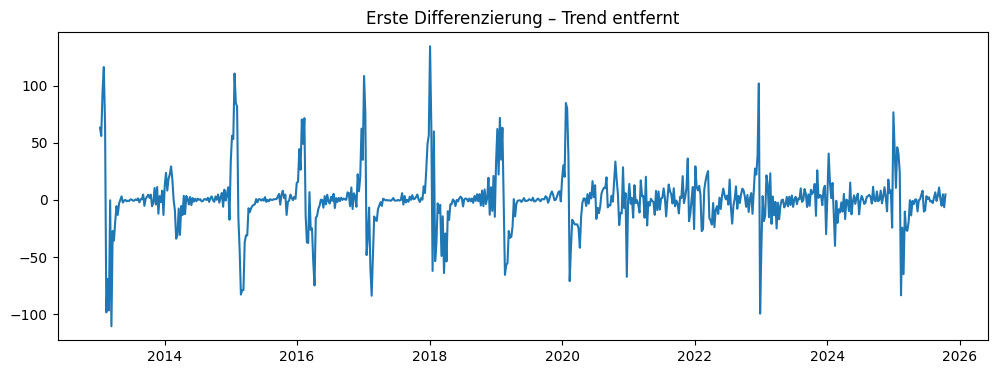

ADF nach 1. Differenzierung: 4.050494700189057e-17


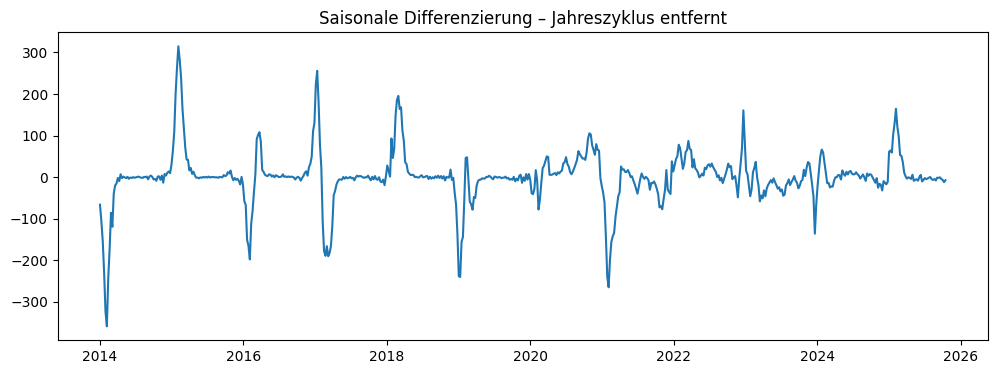

ADF nach saisonaler Differenzierung: 1.5034360030158923e-11


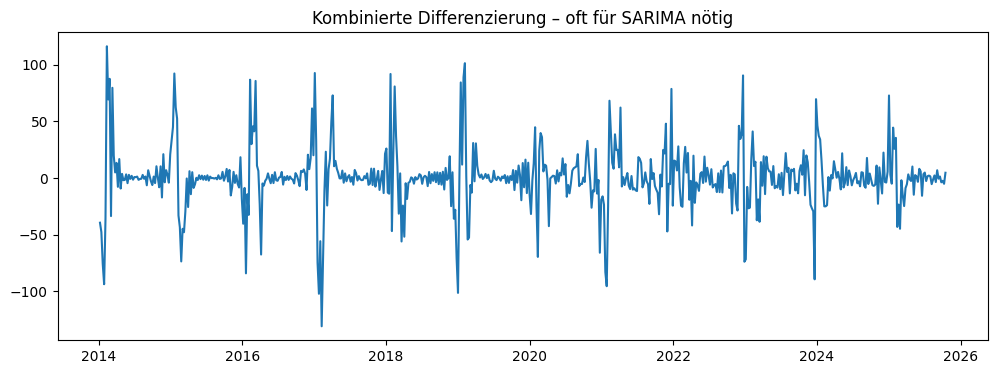

ADF nach kombinierter Differenzierung: 4.4508604920773836e-17


In [18]:
plt.figure(figsize=(12,5))
plt.plot(y, label='Originalserie')
plt.title('Visuelle Prüfung der Stationarität – zeigt Trend und Saisonalität')
plt.legend()
plt.show()

rolling_mean = y.rolling(window=52).mean()  # 1 Jahr
rolling_std = y.rolling(window=52).std()

plt.figure(figsize=(12,6))
plt.plot(y, label='Original')
plt.plot(rolling_mean, label='Rollender Mittelwert (1 Jahr)')
plt.plot(rolling_std, label='Rollende Standardabweichung')
plt.title('Rolling Mean & Std – zeigt Nicht-Stationarität')
plt.legend()
plt.show()

# ==================================
# STEP 3: Augmented Dickey-Fuller-Test
# (Test: ist die Serie stationär?)
# ==================================

from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(y.dropna())
print("ADF-Statistik:", adf_result[0])
print("p-Wert:", adf_result[1])
print("Kritische Werte:", adf_result[4])


# ==================================
# STEP 4: Erste Differenzierung
# (Entfernt Trend, wie wenn man nur die Veränderung betrachtet)
# ==================================

y_diff1 = y.diff().dropna()

plt.figure(figsize=(12,4))
plt.plot(y_diff1)
plt.title('Erste Differenzierung – Trend entfernt')
plt.show()

print("ADF nach 1. Differenzierung:", adfuller(y_diff1)[1])

# ==================================
# STEP 5: Saisonale Differenzierung (Lag = 52 Wochen)
# (Entfernt die jährliche Influenza-Saison)
# ==================================

y_diff_season = y.diff(52).dropna()

plt.figure(figsize=(12,4))
plt.plot(y_diff_season)
plt.title('Saisonale Differenzierung – Jahreszyklus entfernt')
plt.show()

print("ADF nach saisonaler Differenzierung:", adfuller(y_diff_season)[1])


# ==================================
# STEP 6: Kombinierte Differenzierung
# (Entfernt Trend + Saisonalität – meist beste Wahl)
# ==================================

y_diff_both = y.diff().diff(52).dropna()

plt.figure(figsize=(12,4))
plt.plot(y_diff_both)
plt.title('Kombinierte Differenzierung – oft für SARIMA nötig')
plt.show()

print("ADF nach kombinierter Differenzierung:", adfuller(y_diff_both)[1])